In [22]:
import functools as ft
import pickle
import time
from datetime import datetime

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import Array, Float, Real

from snnax import (
    SpikingNeuralNet,
    expected_signature_loss,
    marcus_lift,
    spike_MAE_loss,
    spike_MSE_loss,
)

SAVE_IDX = datetime.today().strftime("%Y-%m-%d-%H")
key = jr.PRNGKey(12345)

## Generate data

In [2]:
steps = 1500
num_save = 2
max_spikes = 3
w = jnp.array([[0.0]])
network = jnp.array([[True]])
potential_spike_cap = 2
t0 = 0
t1 = 5
v_reset = 1.4
v_th = 1
alpha = 3e-2
tau_s = 1
beta = 5
mu = np.array([15, 0])
dt0 = 1e-2
diffusion = True

sample_sizes = [16, 32, 64, 128]
sigmas = [0.25, 0.5]

c = 1.5  # input current (estimand 1)


# Cap exp function for numerical stability
def intensity_fn(v: Float) -> Float:
    return jnp.exp(beta * (jnp.minimum(v - v_th, 10))) / tau_s


@jax.vmap
def get_marcus_lifts(spike_times, spike_marks):
    return marcus_lift(t0, t1, spike_times, spike_marks)


@eqx.filter_jit
def get_data(
    data_size,
    c,
    s,
    key,
):
    gen_key, init_key = jr.split(key, 2)
    y0 = jnp.full((data_size, 1), 0)
    sigma = jnp.array([[s, 0.0], [0.0, 0.0]])

    def input_current(t: Float) -> Array:
        return jnp.array([c])

    snn_true = SpikingNeuralNet(
        num_neurons=1,
        intensity_fn=intensity_fn,
        v_reset=v_reset,
        alpha=alpha,
        w=w,
        network=network,
        mu=mu,
        sigma=sigma,
        key=init_key,
        diffusion=diffusion,
    )

    sol = snn_true(
        input_current,
        t0,
        t1,
        max_spikes,
        data_size,
        key=gen_key,
        i0=y0,
        v0=y0,
        num_save=num_save,
        dt0=dt0,
    )

    spike_trains = get_marcus_lifts(sol.spike_times, sol.spike_marks)

    return spike_trains


def dataloader(data, batch_size, loop, *, key):
    spike_trains = data
    data_size, _, _ = spike_trains.shape
    indices = jnp.arange(data_size)
    while True:
        if batch_size == data_size:
            yield spike_trains
            if not loop:
                break
        perm = jr.permutation(key, indices)
        key = jr.split(key, 1)[0]
        start = 0
        end = batch_size
        while end < data_size:
            batch_perm = perm[start:end]
            yield spike_trains[batch_perm]
            start = end
            end = start + batch_size
        if not loop:
            break

## Models

In [3]:
class SNN(eqx.Module):
    c: Real

    def __call__(self, s, batch_size, key):
        return get_data(batch_size, self.c, s, key)

## Loss functions

In [4]:
# First n spikes moment matching loss
@eqx.filter_jit
def fs_loss(model, data, s, batch_size, key, n=1):
    spike_trains_gen = model(s, batch_size, key)
    return spike_MSE_loss(spike_trains_gen, data, n=n)


# Expected signature loss on spike trains
@eqx.filter_jit
def spike_train_es_loss(model, data, s, batch_size, key, depth=2, match_spikes=True):
    spike_trains_gen = model(s, batch_size, key)
    return expected_signature_loss(spike_trains_gen, data, depth=depth, match_spikes=match_spikes)


# First n average spike times L1 loss
@eqx.filter_jit
def fs_mae_loss(model, data, s, batch_size, key, n=1):
    spike_trains_gen = model(s, batch_size, key)
    return spike_MAE_loss(spike_trains_gen, data, n=n)

## Training loop

In [5]:
@eqx.filter_jit
def make_step(
    model,
    grad_loss,
    optim,
    data,
    s,
    batch_size,
    opt_state,
    key,
):
    loss, grads = grad_loss(model, data, s, batch_size, key)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


def train(
    c,
    loss,
    *,
    test_loss=None,
    lr=1e-3,
    batch_size=128,
    s=0.5,
    steps=500,
    steps_per_print=10,
    data_size=1024,
    seed=567,
):
    key = jr.PRNGKey(seed)
    (
        data_key,
        test_key,
        c_key,
        dataloader_key,
        step_key,
    ) = jr.split(key, 5)

    c_init = jr.uniform(c_key, minval=0.5, maxval=2.5)
    generator = SNN(c=c_init)

    grad_loss = eqx.filter_value_and_grad(loss)
    if test_loss is None:
        test_loss = ft.partial(fs_mae_loss, n=max_spikes)

    # Generate data: We do it in batches since if the data size is too large
    # the underlying DE that is solved won't be too high-dimensional.
    assert data_size % batch_size == 0
    num_batches = data_size // batch_size
    spike_trains = jnp.zeros((data_size, 2 * max_spikes, 2))
    print("Generating data...")
    for i in range(num_batches):
        data_key = jr.fold_in(data_key, i)
        spike_train = get_data(batch_size, c, s, data_key)
        li, ui = i * batch_size, (i + 1) * batch_size
        spike_trains = spike_trains.at[li:ui].set(spike_train)
        print(f"Batch {i + 1} / {num_batches} done.")
    data = spike_trains

    test_data = get_data(batch_size, c, s, test_key)
    print("Data generated. Starting training...")

    c_true = c
    loss_hist = []
    test_loss_hist = []
    c_hist = []
    optim = optax.rmsprop(lr, decay=0.7, momentum=0.3)
    opt_state = optim.init(eqx.filter(generator, eqx.is_inexact_array))
    infinite_dataloader = dataloader(data, batch_size, loop=True, key=dataloader_key)

    for step, dat_i in zip(range(steps), infinite_dataloader):
        start = time.time()
        step = jnp.asarray(step)
        step_key = jr.fold_in(step_key, step)
        score, generator, opt_state = make_step(
            generator,
            grad_loss,
            optim,
            dat_i,
            s,
            batch_size,
            opt_state,
            step_key,
        )
        test_score = test_loss(generator, test_data, s, batch_size, step_key)
        c_current = generator.c
        loss_hist.append(score)
        test_loss_hist.append(test_score)
        c_hist.append(c_current)
        end = time.time()
        if (step % steps_per_print) == 0 or step == steps - 1:
            print(
                f"Step: {step}, Loss: {score}, Test loss: {test_score},"
                f"Computation time: {end - start}"
            )

    results = {
        "model": generator,
        "loss_hist": loss_hist,
        "test_loss_hist": test_loss_hist,
        "c_hist": c_hist,
        "c_true": c_true,
        "sigma": s,
        "sample_size": data_size,
    }
    return results

In [6]:
loss_fns = {
    "sig_mmd": ft.partial(spike_train_es_loss, depth=3),
    "fs_mse": ft.partial(fs_loss, n=3),
}

res_dict = {}
for k, fn in loss_fns.items():
    res_dict[k] = []
    for s in sigmas:
        for n in sample_sizes:
            res_dict[k].append(train(c, fn, steps=steps, data_size=n, batch_size=n, s=s))

    # Save results
    fname = "./data/single_neuron_" + k + "_" + SAVE_IDX
    with open(fname, "wb") as f:
        pickle.dump(res_dict[k], f)
    print("")

Generating data...
Batch 1 / 1 done.
Data generated. Starting training...
Step: 0, Loss: 43.13505172729492, Test loss: 3.8753509521484375, Computation time: 13.689468145370483
Step: 10, Loss: 46.16484832763672, Test loss: 4.002847671508789, Computation time: 0.22700715065002441
Step: 20, Loss: 43.8704948425293, Test loss: 4.203149318695068, Computation time: 0.16440081596374512
Step: 30, Loss: 41.78276824951172, Test loss: 4.056558609008789, Computation time: 0.21630597114562988
Step: 40, Loss: 43.112117767333984, Test loss: 3.8857369422912598, Computation time: 0.2420358657836914
Step: 50, Loss: 42.79145050048828, Test loss: 4.2020583152771, Computation time: 0.18342185020446777
Step: 60, Loss: 44.8486442565918, Test loss: 3.9637413024902344, Computation time: 0.206740140914917
Step: 70, Loss: 46.42426681518555, Test loss: 4.065176963806152, Computation time: 0.20863699913024902
Step: 80, Loss: 42.33066940307617, Test loss: 4.207860469818115, Computation time: 0.17086315155029297
Step

## Plot results

In [19]:
def plot_results(res_list, name):
    with plt.style.context("science"):
        fig, ax = plt.subplots(nrows=len(sigmas), ncols=2, figsize=(10, 6))
        for res in res_list:
            n = res["sample_size"]
            s = res["sigma"]
            test_loss_hist = res["test_loss_hist"]
            c_hist = res["c_hist"]
            row_idx = np.searchsorted(sigmas, s)
            ax[row_idx, 0].plot(test_loss_hist, lw=1, alpha=0.7, label=f"{n}")
            ax[row_idx, 1].plot(c_hist, lw=1, alpha=0.7)
        for i in range(len(sigmas)):
            ax[i, 0].set_title(r"$\sigma = $" + f" {sigmas[i]}")
            ax[i, 1].set_title(r"$\sigma = $" + f" {sigmas[i]}")
            ax[i, 0].set_ylabel("Test loss")
            ax[i, 1].set_ylabel(r"$c$")
            ax[i, 0].legend(title="Sample size")
            ax[i, 1].axhline(c, color="grey", linestyle="--")
        ax[len(sigmas) - 1, 0].set_xlabel("Step")
        ax[len(sigmas) - 1, 1].set_xlabel("Step")

        # Save figure
        plt.savefig(
            "./figures/single_neuron_" + name + SAVE_IDX + ".pdf", dpi=200, bbox_inches="tight"
        )

In [31]:
# Load results
res_dict = {}
for k in loss_fns.keys():
    # Change SAVE_IDX if you want to load results from a different run
    fname = "./data/single_neuron_" + k + "_" + SAVE_IDX
    with open(fname, "rb") as f:
        res_dict[k] = pickle.load(f)

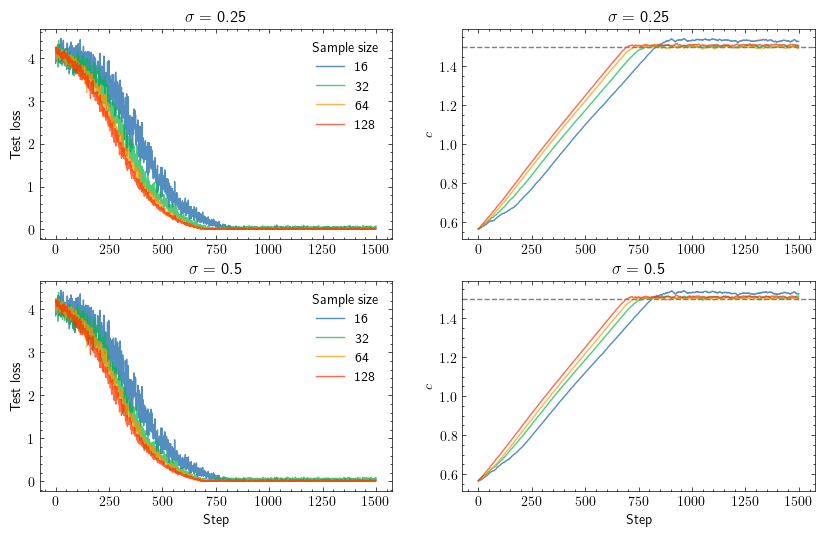

In [32]:
plot_results(res_dict["sig_mmd"], "")

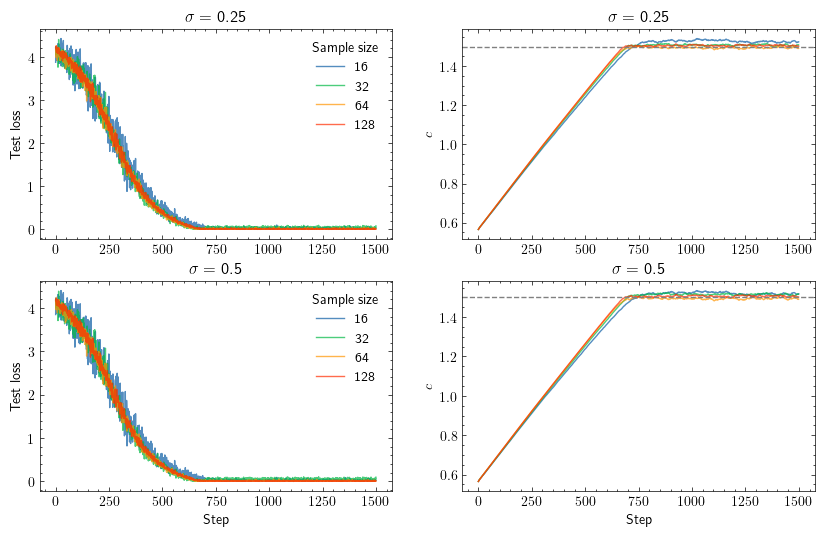

In [33]:
plot_results(res_dict["fs_mse"], "st_mse_")